In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator

In [3]:
#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.style.use('seaborn')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#make colormap indicating cloud phase
liquid = cm.get_cmap('Reds_r', 60)
mixed = cm.get_cmap('RdPu_r', 90)
ice = cm.get_cmap('PuBu_r', 120)

newcolors = np.vstack((ice(np.linspace(0, .5, 60)),
                       mixed(np.linspace(0, .5, 90)),
                       liquid(np.linspace(0, .5, 120))))
newcmp = ListedColormap(newcolors, name='Phases')

In [4]:
path = '/Volumes/KESU/image_data/'

#choose filepath to desired data
calibration_path = '/Volumes/KESU/12152021/'

def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

a_file = h5py.File(path+ 'poldata.h5', "r")
print(a_file.keys())
a_file.close()

<KeysViewHDF5 ['angles', 'nedt', 'responses1', 'responses2', 'responses_err1', 'responses_err2', 'var', 'var1', 'var2', 'waves']>


# Import Calibration Data

Import hdf5 data generated from calculate_POL 

In [5]:
with h5py.File(path+ 'poldata.h5', "r") as file:
    waves = file['/waves'][()]
    measurement = file['/angles'][()]
    
    R1 = file['/responses1'][()]
    R2 = file['/responses2'][()]
    
    E1 = file['responses_err1'][()]
    E2 = file['responses_err2'][()]

## Import Spectral Calibration Data

In [6]:
a_file = h5py.File(calibration_path+ 'calibration.h5', "r")
print(a_file.keys())
a_file.close()

<KeysViewHDF5 ['pixel', 'polarization', 'transmission']>


In [7]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    lambda_c = file['/pixel/wavelength'][()]
    pixel1 = file['/pixel/pixel1'][()]
    pixel2 = file['/pixel/pixel2'][()]

## Import AOLP dependent transmission

This function will correct for differences in transmission over a single period

In [8]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    t_unpol = file['/transmission/t_unpol'][()]
    t_pol = file['/transmission/t_pol'][()]

In [9]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return(T)

In [10]:
def MOD(a,band):
#calculate modulation function for calibration data
    i = band

    start = pixel1[i]
    stop  = pixel2[i]
    i1 = R1[a,start:stop]
    i2 = R2[a,start:stop]
    
    e1 = E1[a,start:stop]
    e2 = E2[a,start:stop]
    
    transmission_aolp = transmission_correction(i1,i2,5)

    I1 = i1/t_unpol[start:stop]
    I2 = i2*transmission_aolp
    
    I1e = e1/t_unpol[start:stop]
    I2e = e2*transmission_aolp

    mod_a = (I1-I2)/(I1+I2)
    mod_e = (e1/100)
                            
    return([mod_a,mod_e])

# Demodulation in Fourier Space

## periodogram

In [24]:
from astropy.timeseries import LombScargle
wavenums = np.divide(1,np.multiply(lambda_c,1e-4))

calibration_path = '/Volumes/KESU/may19/'

0.2952511258694477 0.05048903042117857


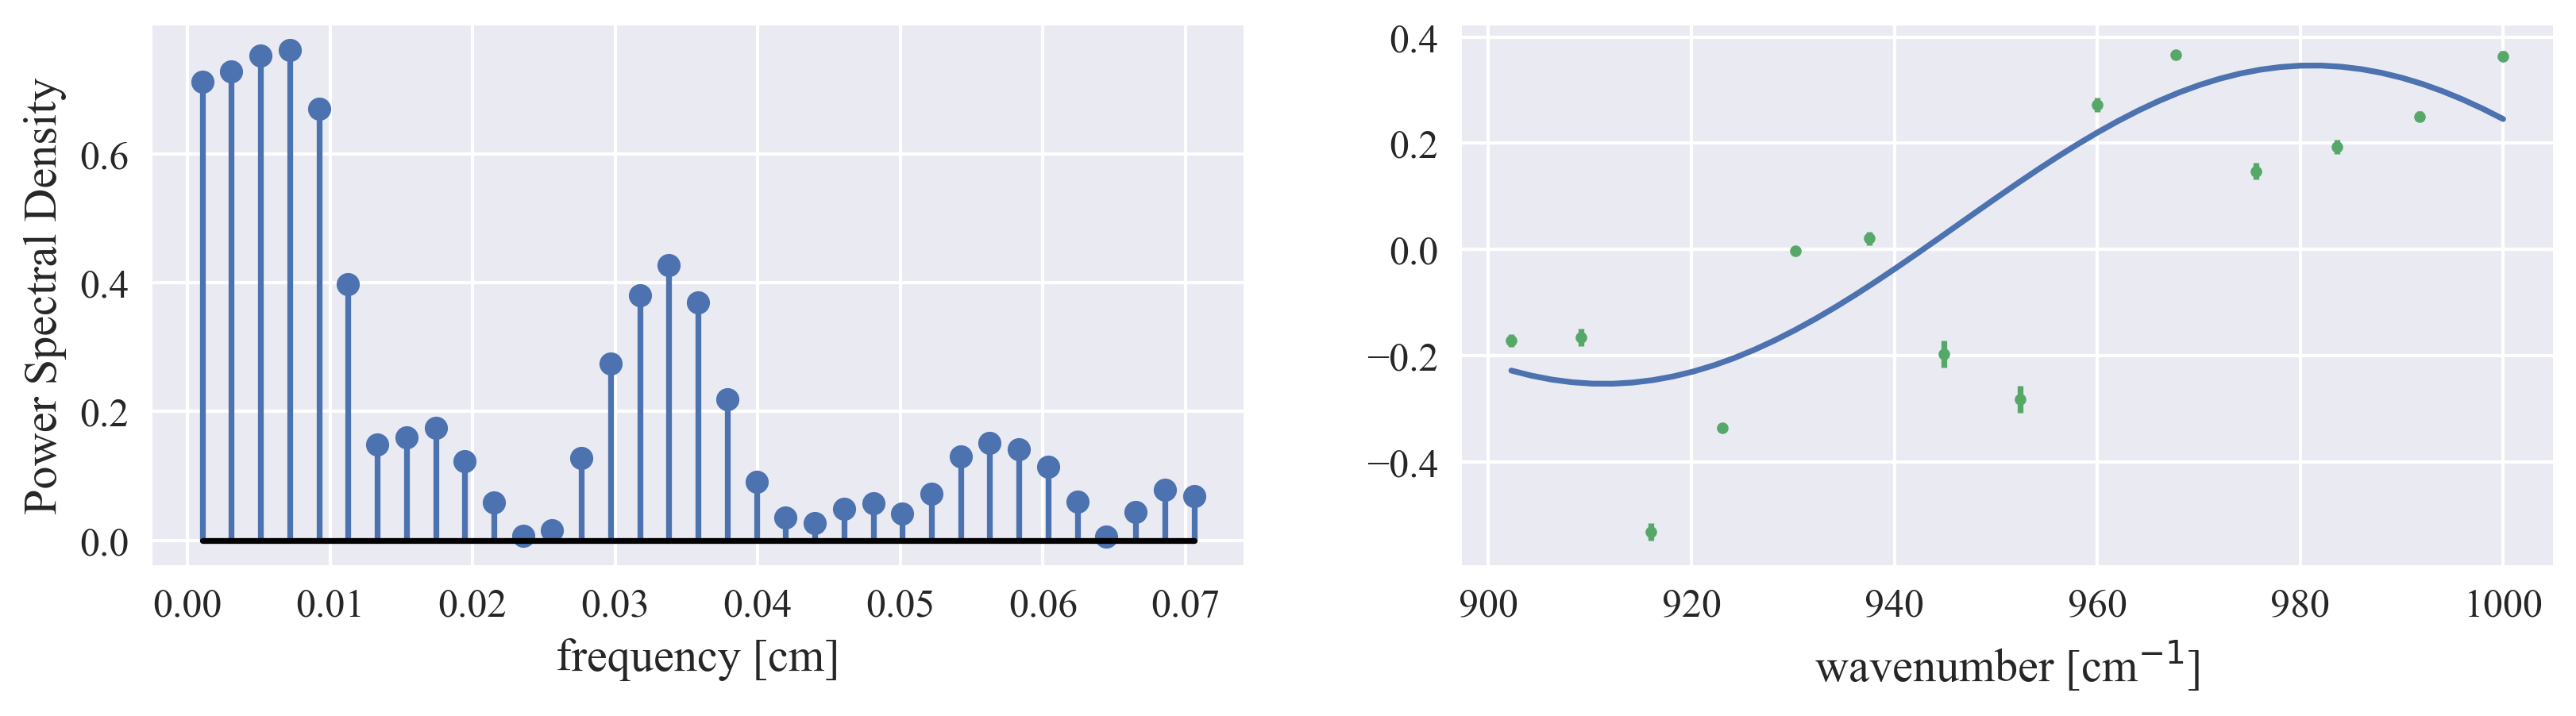

In [25]:
a = 0
j = 35
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;

x = wavenums[start:stop]
[y,dy] = MOD(a,j)

ls = LombScargle(x, y,dy)
frequency, power = ls.autopower(nyquist_factor= 1) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(x[-1],x[0])
y_fit = ls.model(t_fit, best_frequency)

[offset,u,q] = ls.model_parameters( best_frequency)
print(q,u)

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power,basefmt = 'k')
axes[0].set_xlabel('frequency [cm]')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit)
axes[1].set_xlabel('wavenumber [cm$^{-1}$]')
axes[1].errorbar(x,y,yerr = dy,fmt='.')
plt.show()

In [26]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    carrier = file['/polarization/carrier'][()]
    WQ = file['/polarization/WQ'][()]
    WU = file['/polarization/WU'][()]

In [27]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def LombModel(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]
    Wq= WQ[j]
    Wu= WU[j]

    x = wavenums[start:stop]
    [y,dy] = MOD(a,j)

    ls = LombScargle(x, y,dy)
    frequency, power = ls.autopower(nyquist_factor= 1) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    idx = find_nearest(frequency, freq)
    prob = ls.false_alarm_probability(power[idx])  
    if prob < thresh:
        [offset,u,q] = ls.model_parameters(freq)
        if ((u/Wu)**2+(q/Wq)**2)**0.5 > 1:
            [prob,u,q] =[np.NAN,np.NAN,np.NAN]
    else:
        [prob,u,q] =[0,0,0]
    
    return([(u**2 +q**2)**0.5,0.5*np.arctan2(u,q),q,u,prob])

In [28]:
j = 31
ff = 2300
ii = 1400
windows=range(0,34,1)
results = np.zeros([34,ff-ii,5])
for i in range(34):
    j = windows[i]
    for a in range(ii,ff,1):
        results[i,a-ii] = LombModel(a,j,1)  


/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/main.py:216: RuntimeWarning: divide by zero encountered in power
  PLS = METHODS[method](*args, **kwds)
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/main.py:216: RuntimeWarning: invalid value encountered in double_scalars
  PLS = METHODS[method](*args, **kwds)
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:18: RuntimeWarning: divide by zero encountered in true_divide
  return (val / dy ** 2).sum()
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return _weighted_sum(val, dy) / _weighted_sum(np.ones(val.shape), dy)


# Radiometric Calculation

In [29]:
from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from matplotlib import cm
from scipy.optimize import curve_fit
import matplotlib.colors as colors


In [17]:
""" Fitting Function"""
def func(x, a, b):
    y = (x/a)**0.25 +b
    return y

In [18]:
with h5py.File(calibration_path+ 'calibration2.h5', "r") as file:
    nedt = file['/radiometric/nedt'][()]
    var = file['/radiometric/var'][()]

In [19]:
def get_BT(j,i,f):
    bt = []
    Et = []
    for a in range(i,f):
        start = pixel1[j]
        stop  = pixel2[j]

        response = np.sum(R1[a,start:stop]+R2[a,start:stop])
        response_err = np.sum(E1[a,start:stop]+E2[a,start:stop])
        bt.append(func(response,var[j,0],var[j,1]))
        Et.append(func(response+response_err/2,var[j,0],var[j,1])-func(response-response_err/2,var[j,0],var[j,1]))
    return([bt,Et])


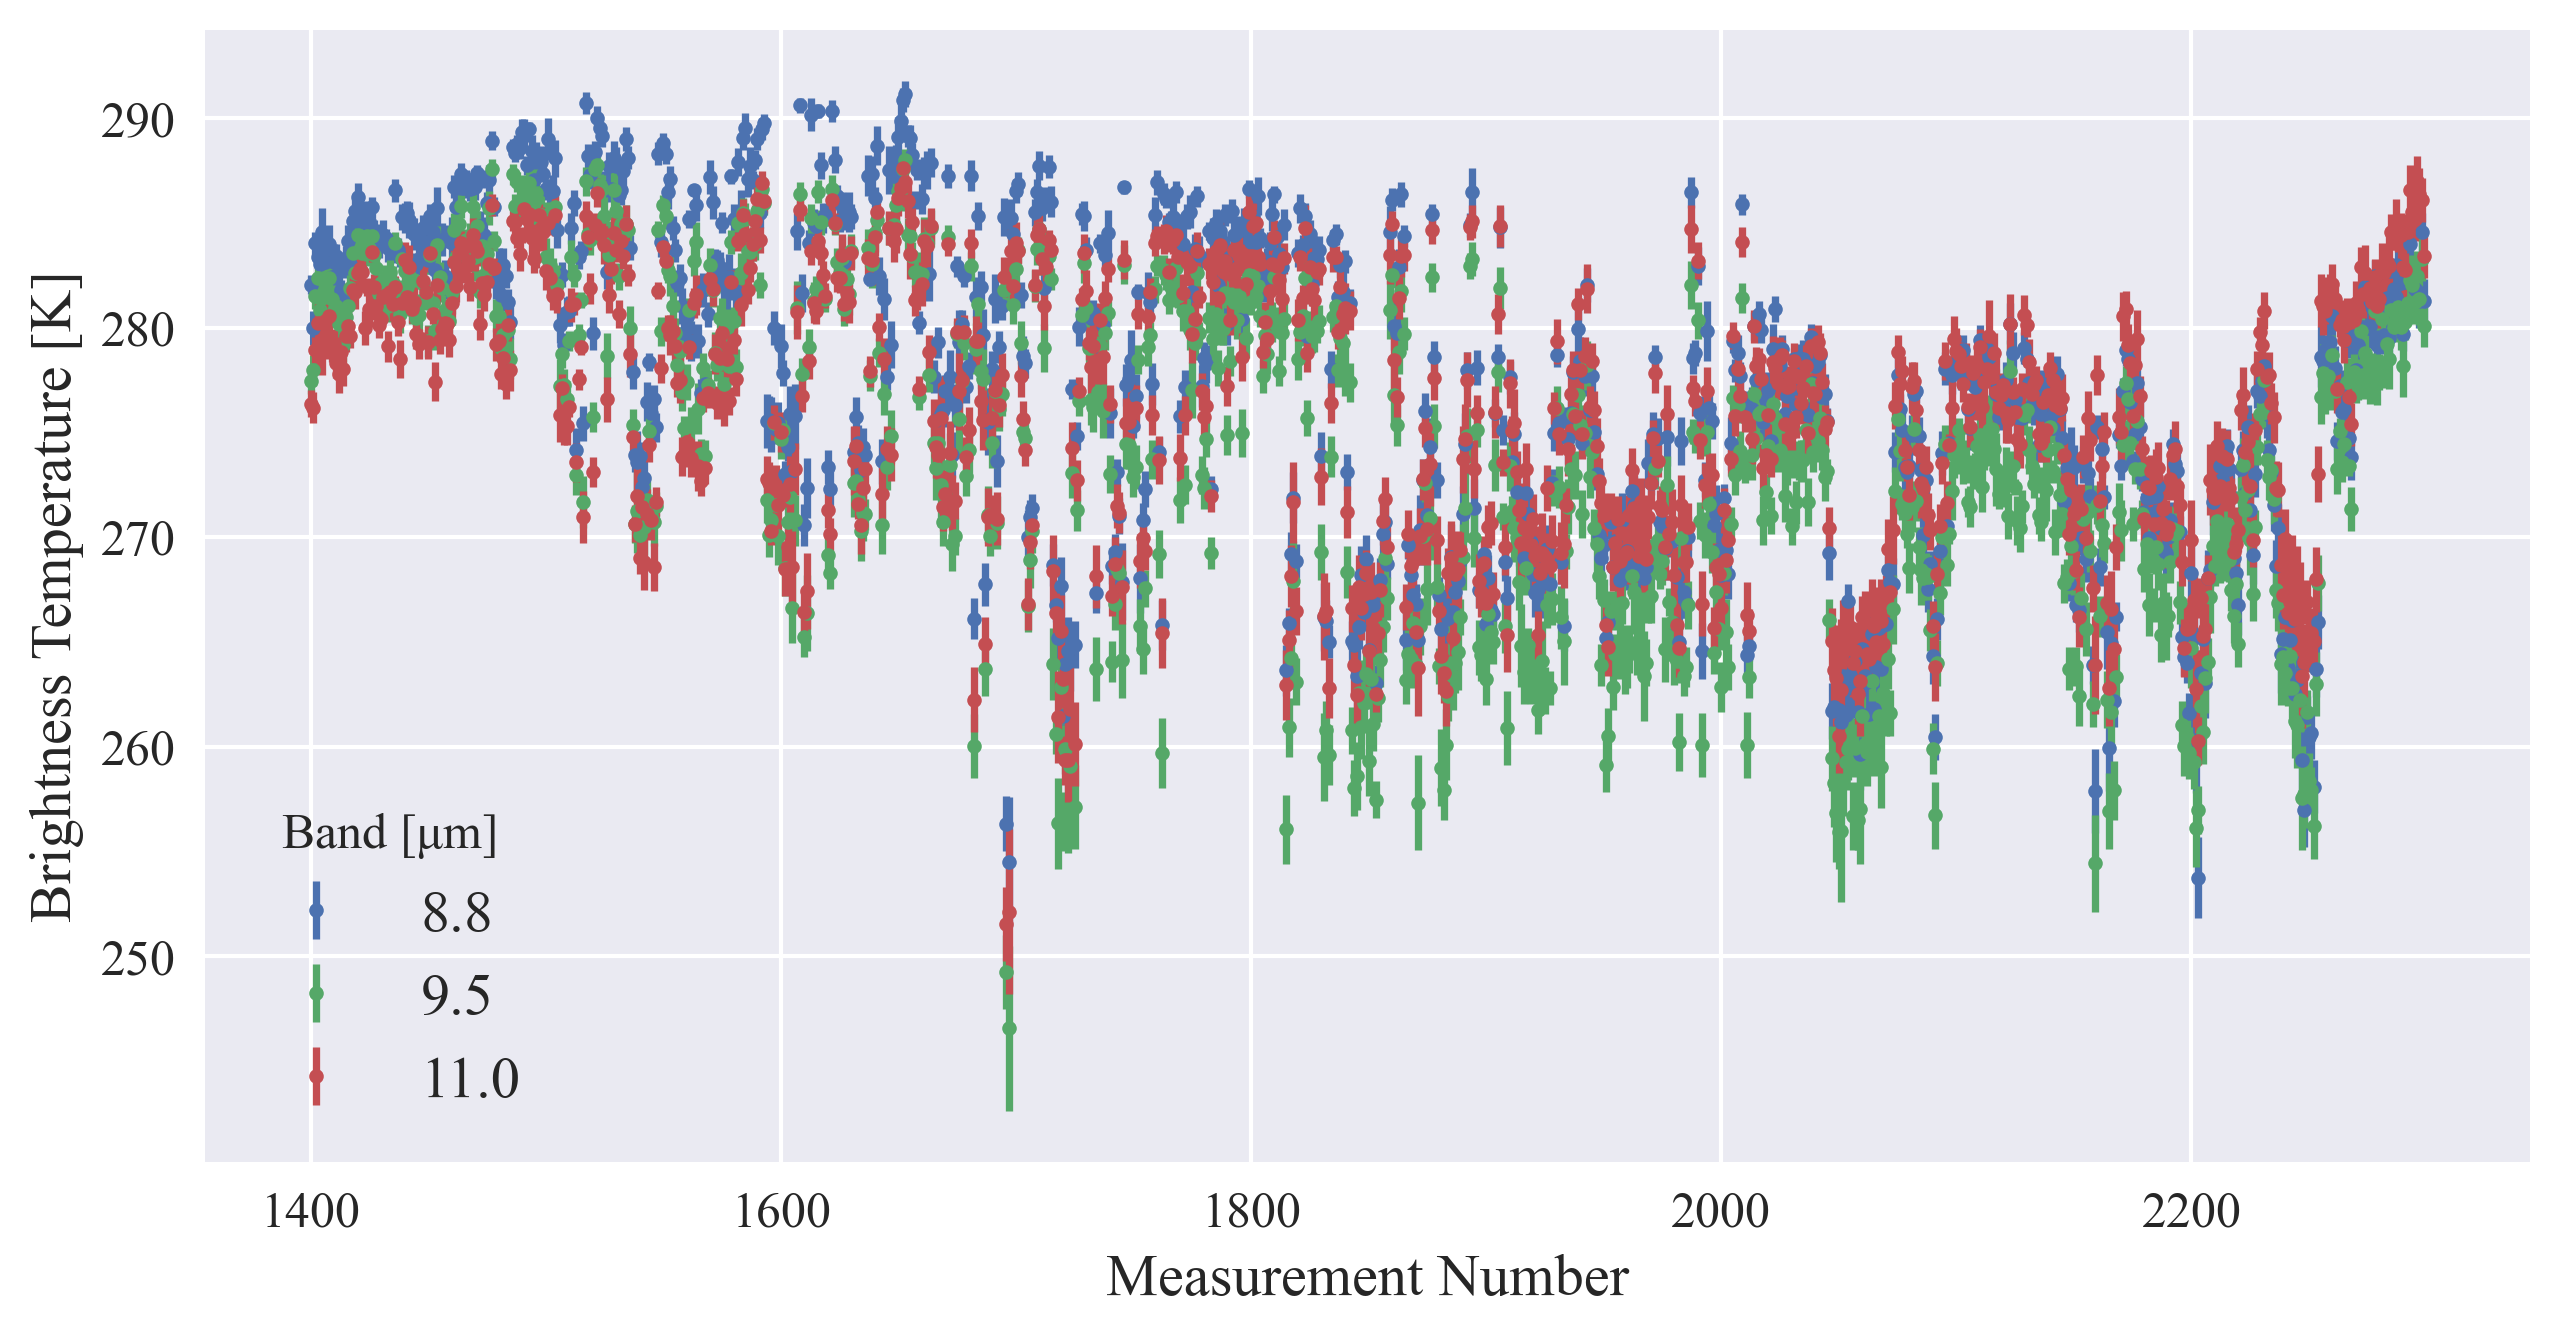

In [22]:

[bt1,et1] = get_BT(17,ii,ff)
[bt2,et2] = get_BT(26,ii,ff)
[bt3,et3] = get_BT(35,ii,ff)
fig = plt.figure(figsize=(10, 5))
plt.gcf().set_dpi(300)
plt.errorbar(range(ii,ff),bt1,yerr = np.divide(et1,1),fmt = '.',label = "8.8")
plt.errorbar(range(ii,ff),bt2,yerr = np.divide(et2,1),fmt = '.',label = "9.5")
plt.errorbar(range(ii,ff),bt3,yerr = np.divide(et2,1),fmt = '.',label = "11.0")
plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]')
plt.ylabel("Brightness Temperature [K]")
plt.xlabel('Measurement Number')
plt.grid(True)
plt.show()

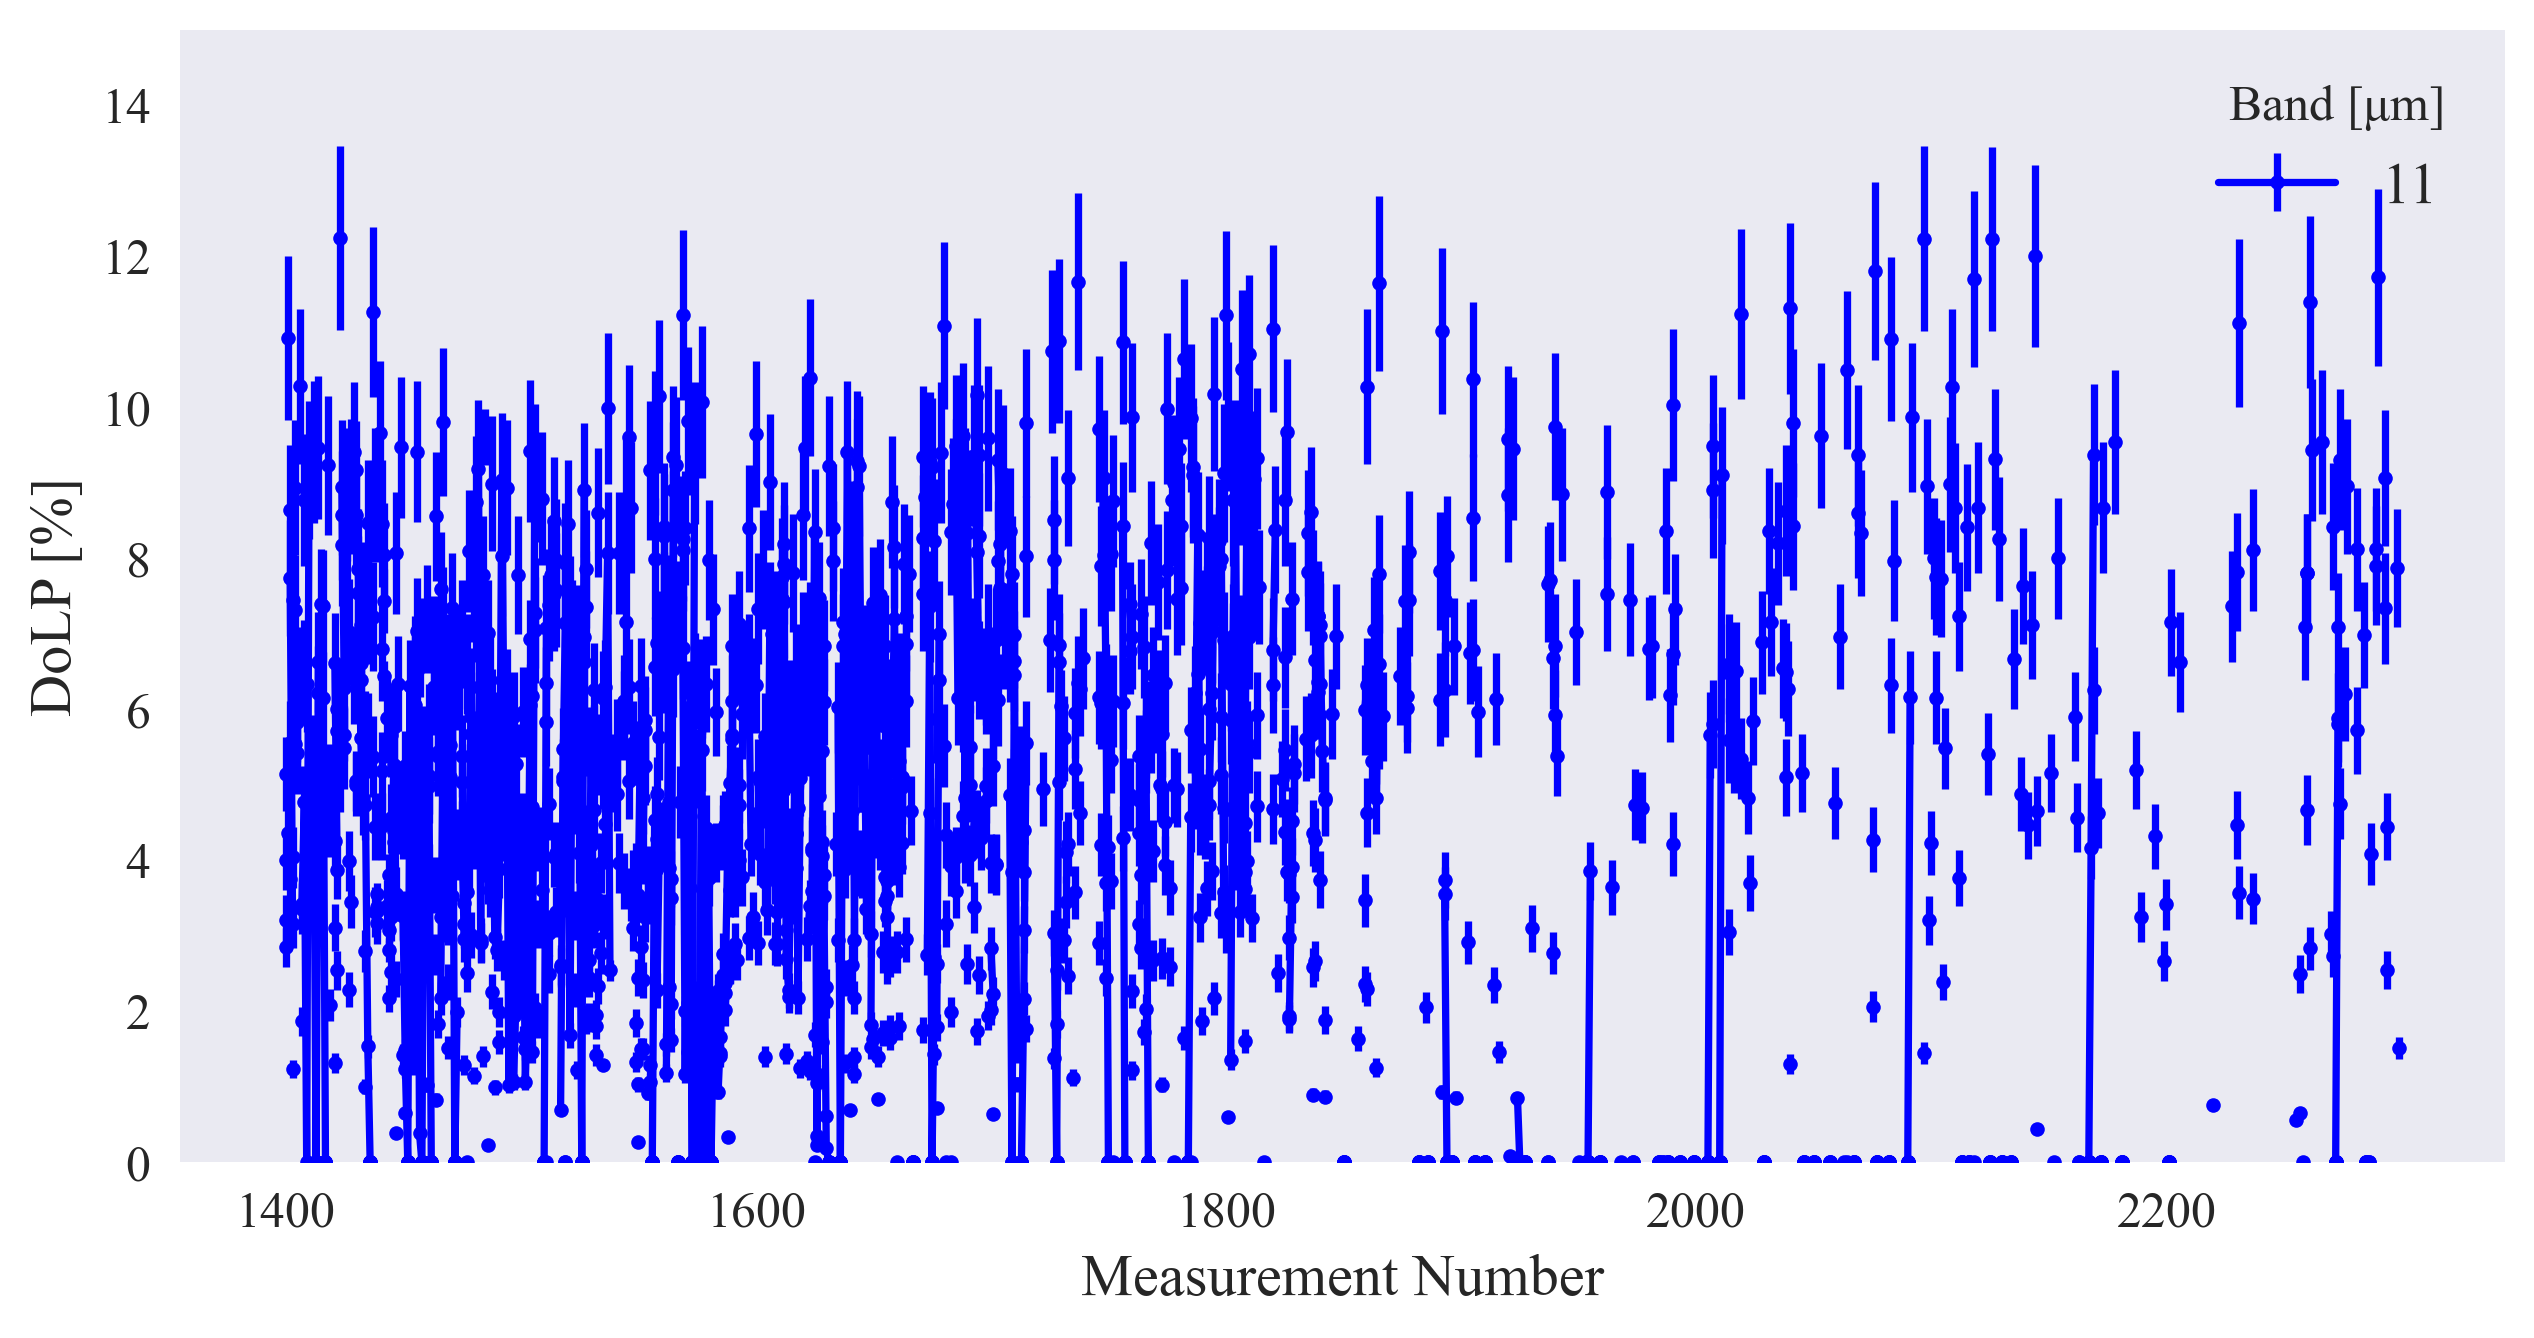

In [30]:
fig = plt.figure(figsize=(10, 5))
plt.gcf().set_dpi(300)
plt.errorbar(range(ii,ff),results[28,:,0]*100,yerr = (results[28,:,4]*results[28,:,0])*10,fmt = '.-b',label = "11 ")
plt.errorbar(range(ii,ff),results[29,:,0]*100,yerr = (results[29,:,4]*results[29,:,0])*10,fmt = '.b')
plt.errorbar(range(ii,ff),results[30,:,0]*100,yerr = (results[30,:,4]*results[30,:,0])*10,fmt = '.b')
plt.errorbar(range(ii,ff),results[31,:,0]*100,yerr = (results[31,:,4]*results[31,:,0])*10,fmt = '.b')
plt.ylim([0,15])

#plt.errorbar(range(ii,ff),results[13,:,0]*100,yerr = (results[13,:,4]*results[13,:,0])*30,fmt = '.-b',label = "8.6 ")
#plt.errorbar(range(ii,ff),results[14,:,0]*100,yerr = (results[14,:,4]*results[14,:,0])*30,fmt = '.b')
#plt.errorbar(range(ii,ff),results[15,:,0]*100,yerr = (results[15,:,4]*results[15,:,0])*30,fmt = '.b')
#plt.errorbar(range(ii,ff),results[16,:,0]*100,yerr = (results[16,:,4]*results[16,:,0])*30,fmt = '.b')


plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]')
plt.ylabel("DoLP [%]")
plt.xlabel('Measurement Number')
plt.grid()
plt.show()

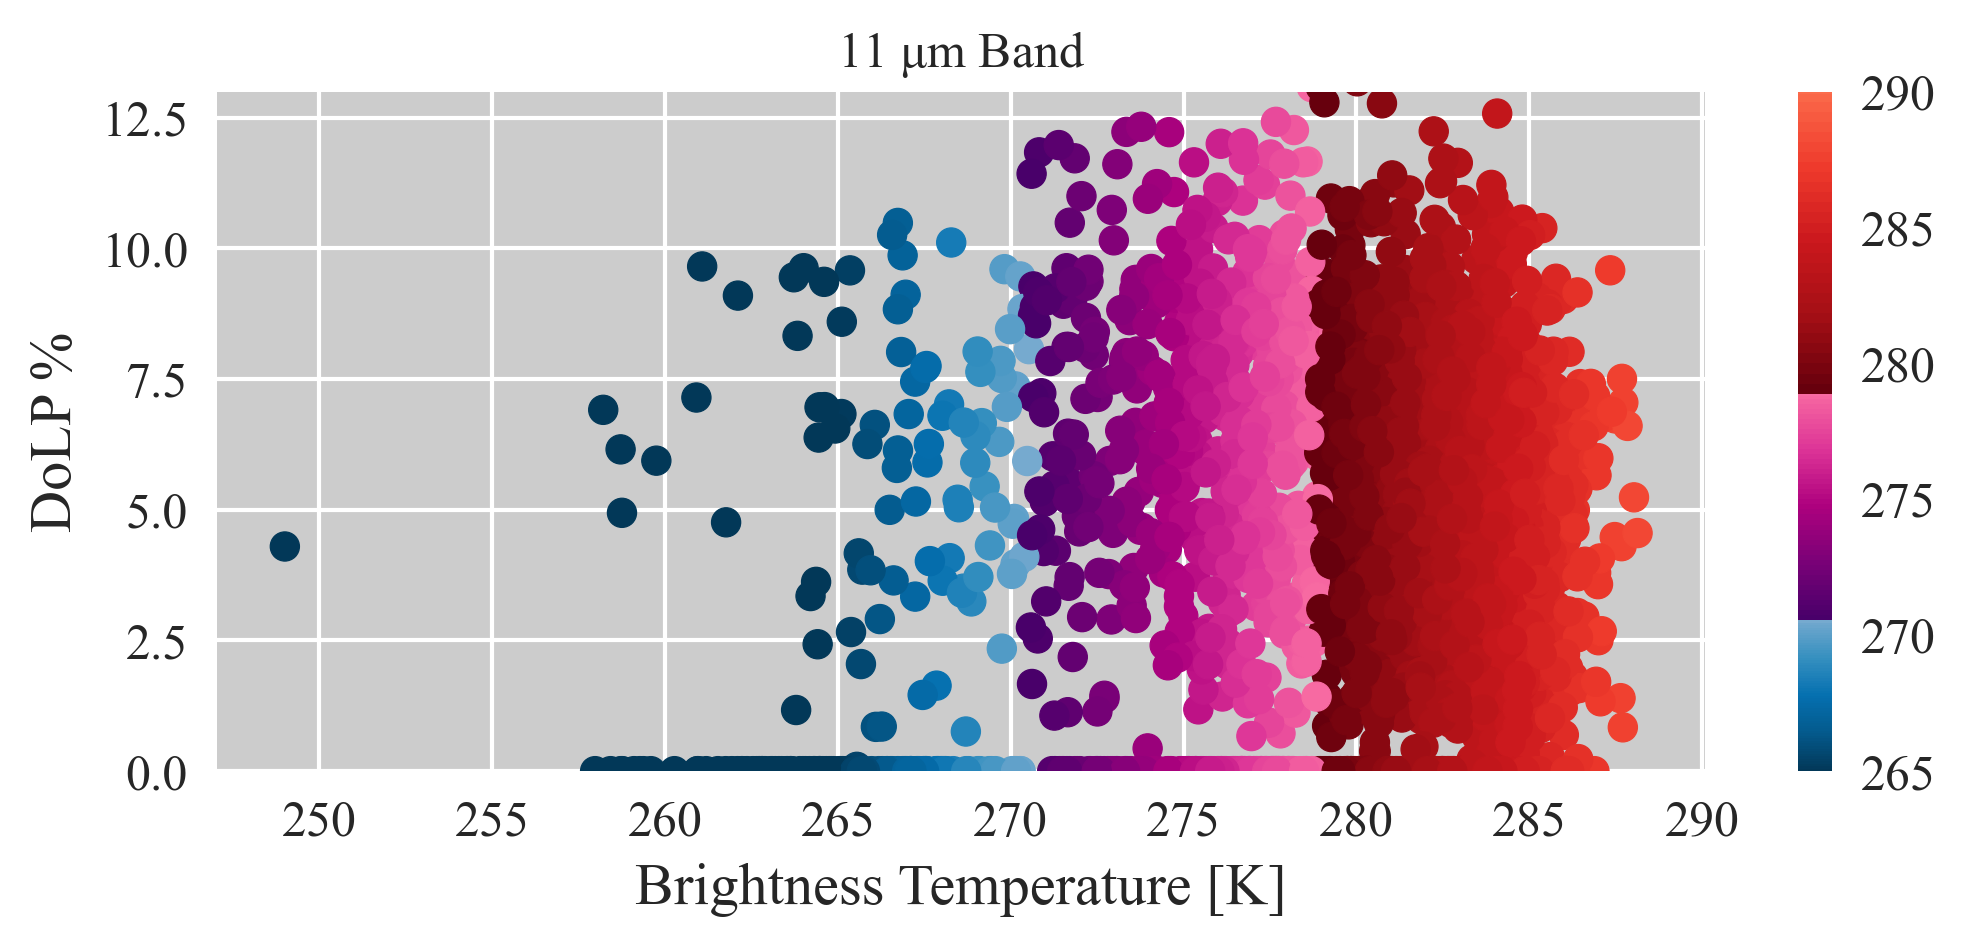

In [31]:
[bt1,et1] = get_BT(28,ii,ff)
[bt2,et2] = get_BT(29,ii,ff)
[bt3,et3] = get_BT(30,ii,ff)
[bt4,et4] = get_BT(31,ii,ff)
[bt5,et5] = get_BT(32,ii,ff)
[bt6,et6] = get_BT(33,ii,ff)

fig = plt.figure(figsize=(8,3))
plt.gcf().set_dpi(300)
ax = fig.add_subplot()
ax.set_facecolor('0.8')
c = ax.scatter(bt1,results[28,:,0]*100, c = bt1, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt2,results[29,:,0]*100, c = bt2, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt3,results[30,:,0]*100, c = bt3, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt4,results[31,:,0]*100, c = bt4, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt5,results[32,:,0]*100, c = bt5, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt6,results[33,:,0]*100, c = bt6,  cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
fig.colorbar(c)
plt.ylim(0,13)

plt.ylabel("DoLP %")
plt.xlabel("Brightness Temperature [K]")
plt.title('11 $\mathdefault{\mu}$m Band')
plt.show()

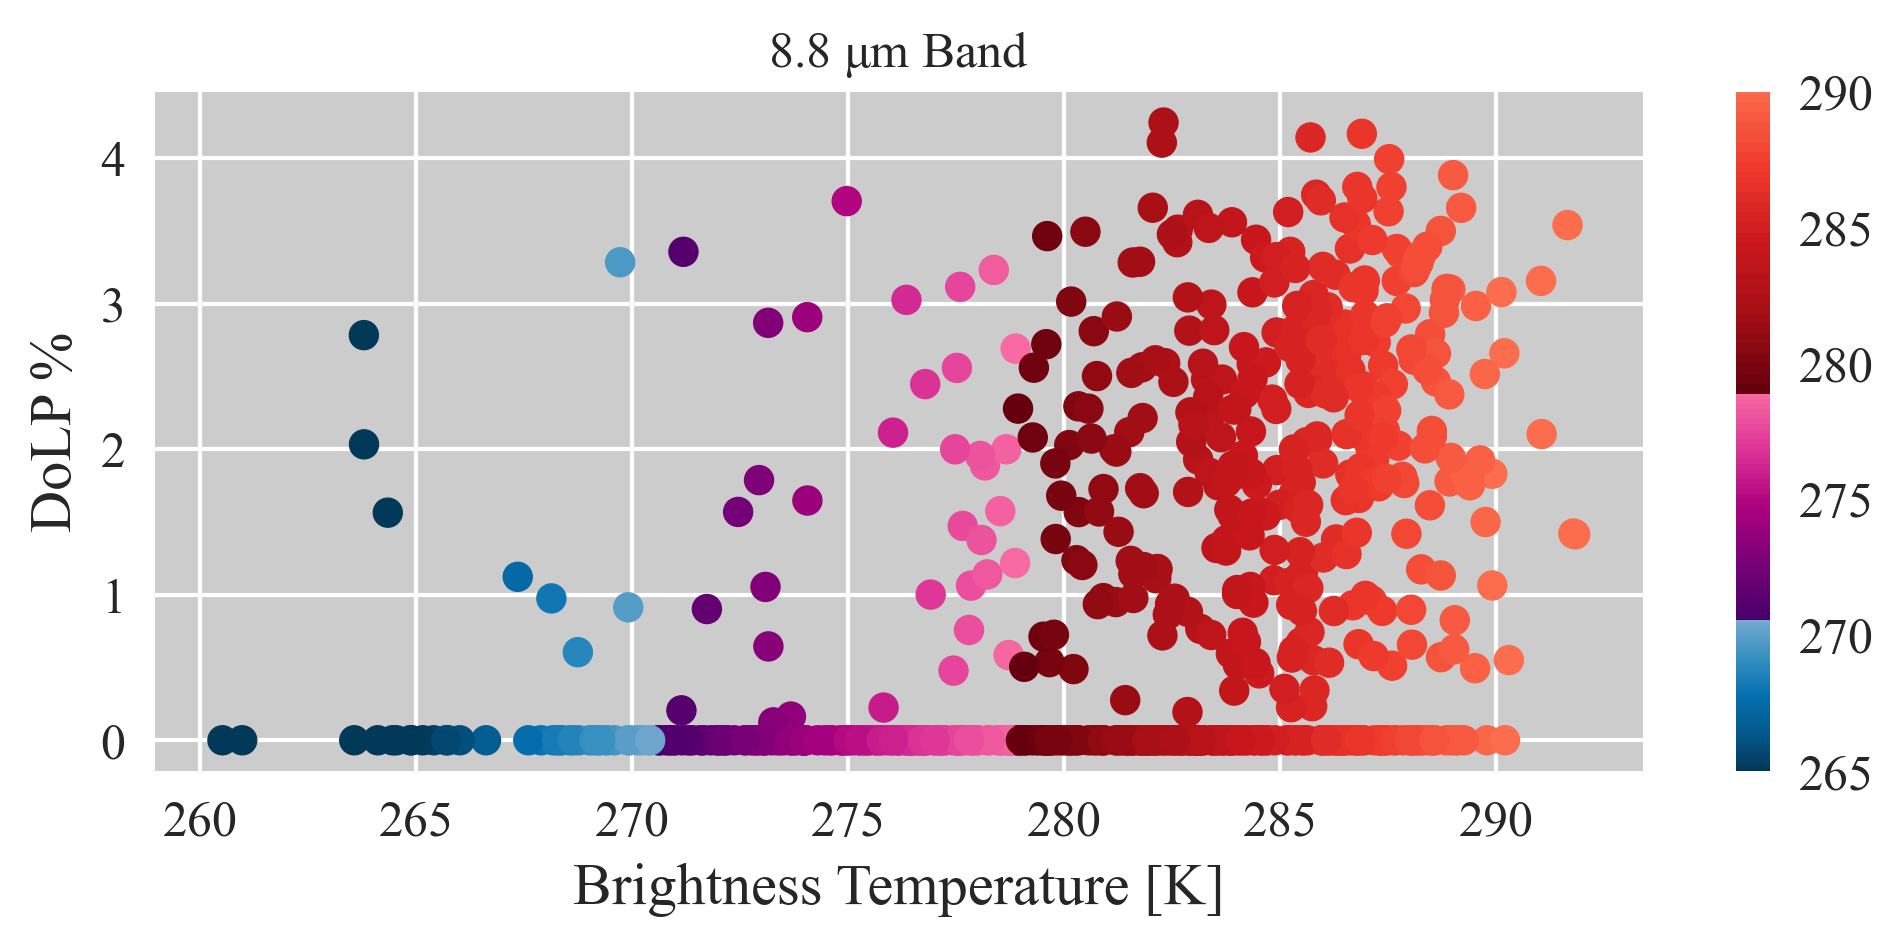

In [32]:
[bt1,et1] = get_BT(5,ii,ff)
[bt2,et2] = get_BT(6,ii,ff)
[bt3,et3] = get_BT(7,ii,ff)
[bt4,et4] = get_BT(8,ii,ff)

fig = plt.figure(figsize=(8,3))
plt.gcf().set_dpi(300)
ax = fig.add_subplot()
ax.set_facecolor('0.8')
c = ax.scatter(bt1,results[15,:,0]*100, c = bt1  , cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt2,results[16,:,0]*100, c = bt2  , cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt3,results[17,:,0]*100, c = bt3, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt4,results[18,:,0]*100, c = bt4 , cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt5,results[9,:,0]*100, c = bt5, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
ax.scatter(bt6,results[10,:,0]*100, c = bt6, cmap=newcmp, alpha=1,vmin = 265,vmax = 290)
fig.colorbar(c)
#plt.ylim(0,13)

plt.ylabel("DoLP %")
plt.xlabel("Brightness Temperature [K]")
plt.title('8.8 $\mathdefault{\mu}$m Band')
plt.show()

In [33]:
import requests

response = requests.get('http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_nq_10_20.dat')
data = response.text 

data_by_line = data.split('\n')
for i in range(0,len(data_by_line)):
   data_by_line[i] = ' '.join(data_by_line[i].split())
   data_by_line[i] = data_by_line[i].split(' ')

In [34]:
w = np.zeros(600)
t = np.zeros(600)
for i in range(0,60000,100):
    j = int(i/100)
    float_lst = list(np.float_(data_by_line[i]))
    w[j] = float_lst[0]
    t[j] = float_lst[1]

 

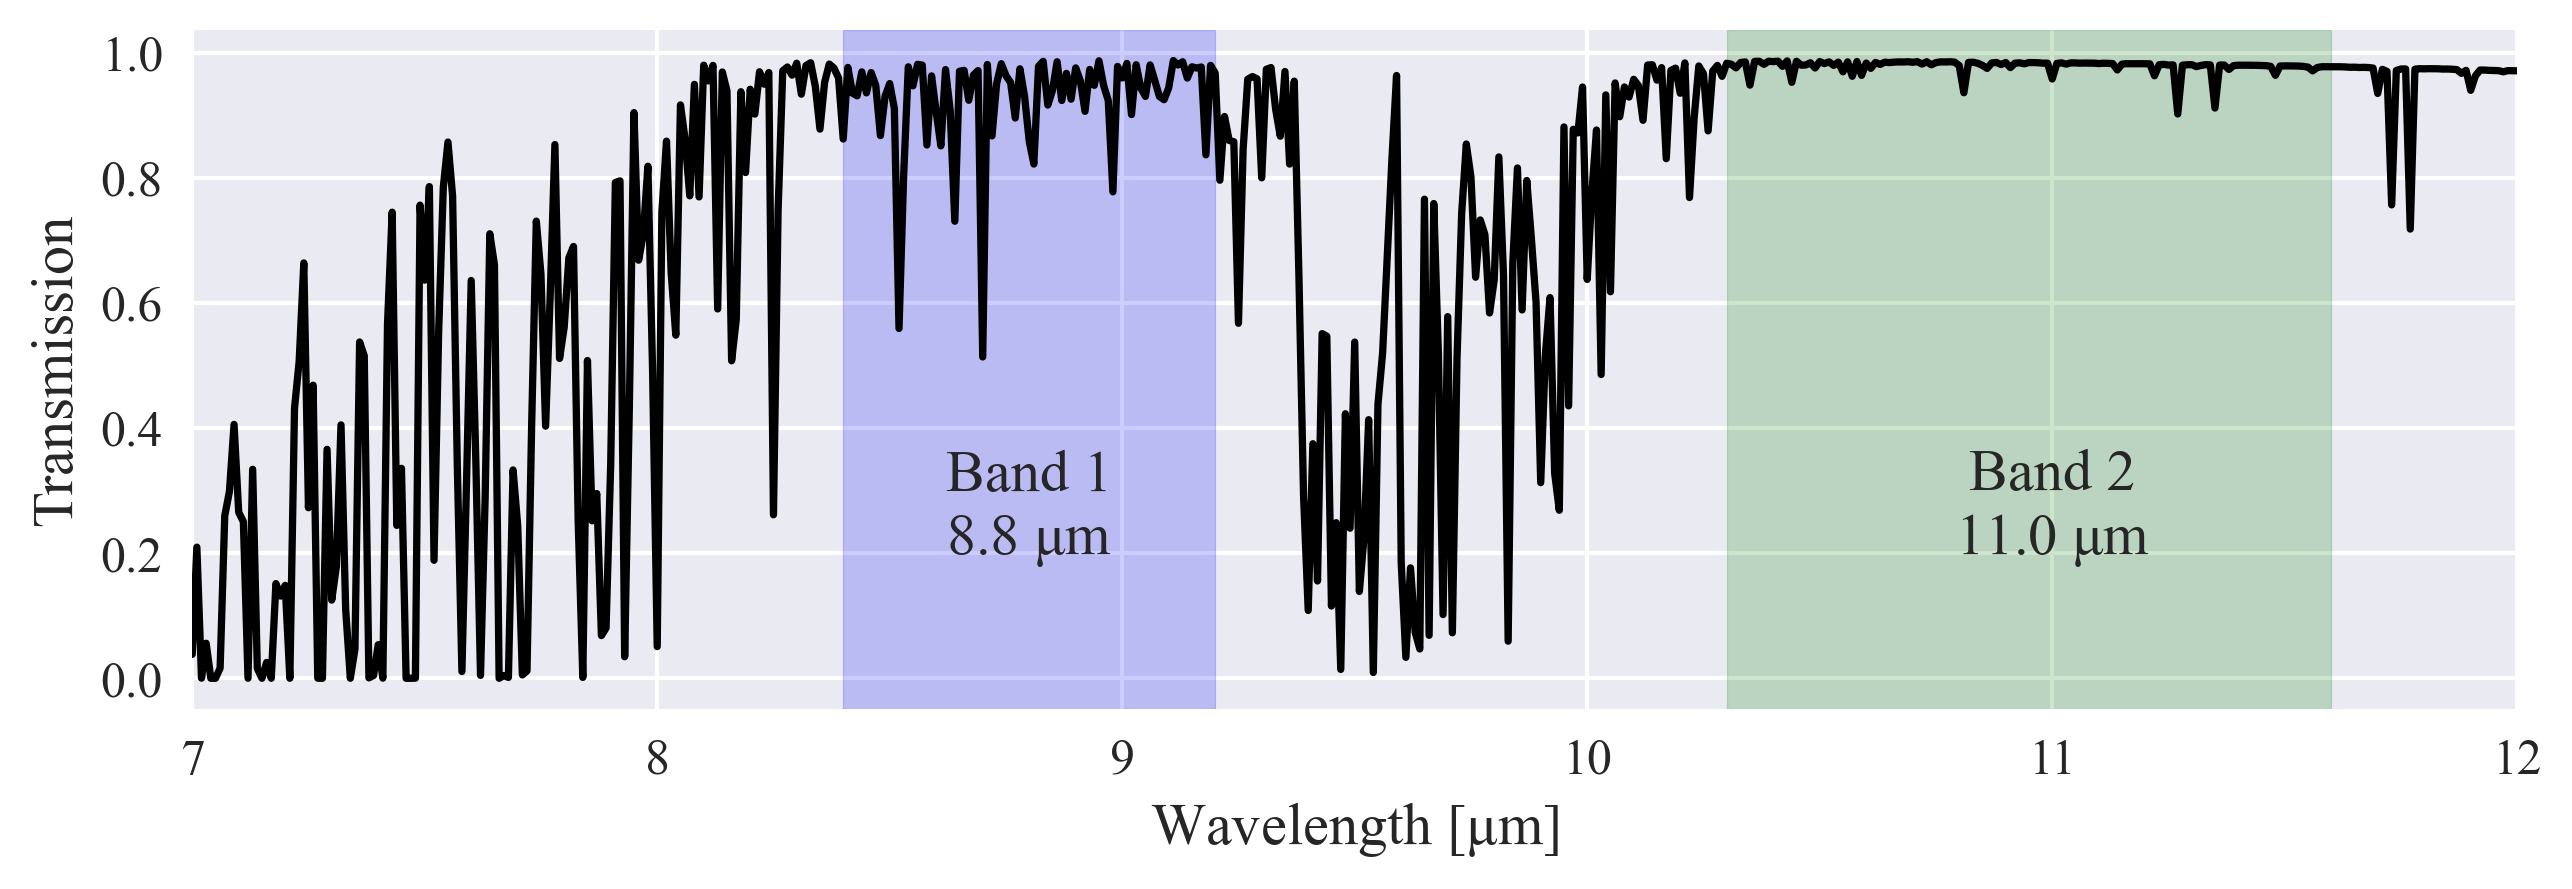

In [35]:
fig = plt.figure(figsize=(10, 3))
plt.gcf().set_dpi(300)
plt.plot(w,t,'k-')
plt.ylabel("Transmission")
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.axvspan(8.4, 9.2, color='blue', alpha=0.2)
plt.axvspan(10.3, 11.6, color='green', alpha=0.2)
plt.xlim(7,12)

plt.text(8.8,.2,"Band 1\n8.8 $\mathdefault{\mu}$m ",fontsize = 14,ha = 'center')
plt.text(11,.2,"Band 2\n11.0 $\mathdefault{\mu}$m ",fontsize = 14,ha = 'center')
plt.show()

In [36]:
(results[28,:,4]*results[28,:,0])*100

array([4.00358836,        nan, 7.73758079, 3.15011659,        nan,
       5.84477433,        nan, 3.42150895, 4.7696601 , 0.        ,
       9.13434782,        nan, 5.38952623, 0.        , 6.62328758,
              nan, 6.14411486, 0.        ,        nan, 2.07967108,
              nan, 6.61773631, 3.86790479,        nan, 8.92369997,
       6.27984142,        nan,        nan,        nan,        nan,
       6.84849233, 7.8629411 , 5.62335283, 4.81736087, 4.73553652,
       1.53690746, 0.        ,        nan,        nan, 2.76523287,
              nan, 8.4352286 , 6.81717042,        nan, 1.58037743,
       3.24905491, 5.2548681 , 3.54955371,        nan,        nan,
       3.25770829, 1.22873623, 0.        , 6.01859647, 1.27550338,
       3.26671369, 6.51192345, 0.38079265, 0.        , 5.49281301,
       2.89486524, 5.11950901, 0.        ,        nan, 6.71830365,
              nan, 2.16270147, 5.70560552, 3.37124006, 3.58869993,
       5.40090774, 6.60746341, 0.        , 1.99058789,        

In [60]:
lambda_c[26]

9.5